<a href="https://colab.research.google.com/github/pcummer/deep_learning_short_projects/blob/main/Protein_folding_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an exploratory project to play around with applying various NLP techniques to predict the secondary structure of a protein from the amino acid sequence. I compare performance to the foundational work in http://www.columbia.edu/~nq6/publications/protein.pdf which reported a best single model accuracy of 62.7% using a sliding window multilayer perceptron.

There's a lot of directions to take this with likely highlights being deploying a proper NLP model like a biLSTM with randomly initialized embeddings for the amino acids, exploring those embeddings to see if they capture the similarities we'd expect i.e. arginine and lysine are close in that space, and incorporating biophysical properties of the amino acids such as charge and flags for special amino acids such as proline.

We won't worry about optimizing the details of model architecture and training for the most part. If we end up with something particularly high performing we may dig into it. We're also not going to bother with a train-val-test split since this work is purely exploratory and the goal is to try interesting things not report rigorous performance. 

In [1]:
# Download our dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/protein-secondary-structure/protein-secondary-structure.train
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/protein-secondary-structure/protein-secondary-structure.test

--2020-11-17 13:26:51--  https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/protein-secondary-structure/protein-secondary-structure.train
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73489 (72K) [application/x-httpd-php]
Saving to: ‘protein-secondary-structure.train’

protein-secondary-s 100%[===================>]  71.77K  --.-KB/s    in 0.1s    

2020-11-17 13:26:52 (543 KB/s) - ‘protein-secondary-structure.train’ saved [73489/73489]

--2020-11-17 13:26:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/molecular-biology/protein-secondary-structure/protein-secondary-structure.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200

In [2]:
import pandas as pd
import numpy as np

# Function to load the text file and return a minimally formatted dataframe
def parse_to_df(path):
  with open(path,'r') as f:
    content = f.readlines()
  df = pd.DataFrame()
  protein_count = 0
  amino_acids = []
  structure = []
  for i in content:
    i = i.strip()
    if 'end' in i:
        df = df.append(pd.DataFrame({'amino_acid':[amino_acids], 'structure':[structure], 'protein_count':[protein_count]}))
        protein_count += 1
        amino_acids = []
        structure = []
    elif len(i) == 3:
      amino_acids.append(i.split(' ')[0])
      structure.append(i.split(' ')[1])
  return df

Here we load the text files for the train and test splits into easily accessed dataframes. We also also assign an index to each amino acid and structure to replace the text character.

In [4]:
# Simple data preparation: load the data from text files, find the unique set of amino acids, convert text characters to indices

df_train_raw = parse_to_df('/content/protein-secondary-structure.train')
df_test_raw = parse_to_df('/content/protein-secondary-structure.test')


unique_amino_acids_in_train = np.unique([item for sublist in df_train_raw.amino_acid for item in sublist])
unique_amino_acids_in_test = np.unique([item for sublist in df_test_raw.amino_acid for item in sublist])
[unique_amino_acids_in_train.append(x) for x in unique_amino_acids_in_test if x not in unique_amino_acids_in_train]

amino_acid_to_index = {}
i=0
for x in unique_amino_acids_in_train:
  amino_acid_to_index[x] = i
  i += 1


structure_to_index = {'_': 0, 'h': 1, 'e': 2}

df_train_raw['amino_acid_index'] = [[amino_acid_to_index[x] for x in y] for y in df_train_raw.amino_acid]
df_test_raw['amino_acid_index'] = [[amino_acid_to_index[x] for x in y] for y in df_test_raw.amino_acid]
df_train_raw['structure_index'] = [[structure_to_index[x] for x in y] for y in df_train_raw.structure]
df_test_raw['structure_index'] = [[structure_to_index[x] for x in y] for y in df_test_raw.structure]

In [5]:
import tensorflow as tf

# This is a very simple data generator to simplify some of the model training below, notably it deals with the variable sequence length by using a batch size of 1
class basicGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, shuffle=True, batch_size=1):
      self.df = df
      self.shuffle = shuffle
      self.batch_size = batch_size
      self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1.0)

    def __getitem__(self, index):
        indexes = np.arange(index * self.batch_size, (index + 1) * self.batch_size)
        batch_input = []
        batch_target = []
        for i in indexes:
            amino_acid_sequence = self.df.amino_acid_index.iloc[i]
            label_sequence = self.df.structure_index.iloc[i]
            batch_input.append(amino_acid_sequence)
            batch_target.append(label_sequence)

        batch_input = np.stack(batch_input)
        batch_target = np.array(batch_target)

        return batch_input, batch_target


In [6]:
# Instantiate our generators for the train and test set
train_generator = basicGenerator(df_train_raw)
test_generator = basicGenerator(df_test_raw)

Here we test a toy model to confirm that our data loading and formatting has worked as expected.

In [ ]:
import tensorflow as tf

# this is pretty close to a minimal sequence model, arguably for a true minimal model the RNN should use a simpler cell than LSTM
input = tf.keras.layers.Input((None, 1))
output = tf.keras.layers.LSTM(3, return_sequences=True, activation='softmax')(input)

toy_model = tf.keras.models.Model(inputs=[input], outputs=[output])
toy_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# fit our model, empirically 10 epochs is about right for the training to plateau
toy_model.fit(train_generator, validation_data=test_generator, epochs=10)

In [ ]:
from sklearn.metrics import classification_report

# there's a lot of list comprehension here, but the end result is simple: a single list of every amino acid and a corresponding single list of every prediction
predictions = [toy_model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

           0       0.55      0.99      0.70      1923
           1       1.00      0.00      0.00       849
           2       0.28      0.01      0.02       748

    accuracy                           0.54      3520
   macro avg       0.61      0.33      0.24      3520
weighted avg       0.60      0.54      0.39      3520



Unsurprisingly, our performance on the validation set is essentially equivalent to the majority baseline (i.e. guessing no structure for every amino acid which occurs 54.6% of the time). Now comes the fun part where we move to a real model and start pushing our performance. 

In [ ]:
# Add a randomly initialized embedding layer to our model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.LSTM(3, return_sequences=True, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# Train a fair bit longer since it's actually learning something
model.fit(train_generator, validation_data=test_generator, epochs=40)

In [ ]:
# Calculate updated performance metrics
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71      1923
           1       0.42      0.26      0.32       849
           2       0.45      0.10      0.17       748

    accuracy                           0.56      3520
   macro avg       0.49      0.41      0.40      3520
weighted avg       0.52      0.56      0.50      3520



Just adding in the randomly initialized embedding layer has moved us to a model that's beginning to train meaningfully. The overall accuracy is only slightly improved, but the macro f1 is massively improved as the model now makes an attempt at guessing the minority classes.

The plateauing of the model performance on the train set indicates that we don't have sufficient model complexity (or sufficiently rich inputs) to to fit this data. Expanding model complexity is easier than enriching the data so we'll start there.

In [ ]:
# Add a single dense layer after the LSTM that operates independently on each time step (essentially like adding another RNN layer with no memory)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.LSTM(4, return_sequences=True, activation='relu'))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# Same training regimen as above
model.fit(train_generator, validation_data=test_generator, epochs=40)

In [ ]:
# Calculate updated performance metrics
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

           0       0.63      0.80      0.70      1923
           1       0.43      0.37      0.40       849
           2       0.42      0.19      0.26       748

    accuracy                           0.57      3520
   macro avg       0.49      0.45      0.45      3520
weighted avg       0.54      0.57      0.54      3520



We've got more overfitting with the extra capacity (not seen in the above test set performance), but not a significant performance increase. We can enrich the input data simply by swapping to a biLSTM. This allows each prediction to look at the following amino acids in addition to the prior amino acids.

In [ ]:
# Very easy to swap to biLSTM with just the Bidirectional layer wrapping the LSTM
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [ ]:
# Increase the training time since it is continuing to learn longer
model.fit(train_generator, validation_data=test_generator, epochs=80)

In [ ]:
# Calculate updated performance metrics
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

no_structure       0.64      0.85      0.73      1923
 alpha_helix       0.49      0.37      0.42       849
  beta_sheet       0.46      0.21      0.29       748

    accuracy                           0.60      3520
   macro avg       0.53      0.48      0.48      3520
weighted avg       0.57      0.60      0.56      3520



We've got another small increase from the biLSTM and could likely chase a significantly larger increase with refinement of the architecture and training regime. At this point we can see if our embeddings are capturing meaningful properties of the amino acids.

In [ ]:
from sklearn.decomposition import PCA

# Use a pca (primary component analysis) to reduce the dimensionality for visual inspection
pca = PCA(2)
embedding_array = model.layers[0].get_weights()[0]
embedding_2d = pca.fit_transform(embedding_array)

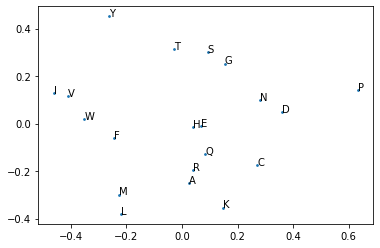

In [ ]:
import matplotlib.pyplot as plt

# plot the embedding for each amino acid
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=3)
for key in amino_acid_to_index:
  plt.annotate(key, (embedding_2d[amino_acid_to_index[key], 0], embedding_2d[amino_acid_to_index[key], 1]))

The answer to the above question is by and large, no, not really. One can argue for certain points such as proline, an unusual amino acid, being isolated, but it's a bit like reading tea leaves with this lack of structure. This is an excellent argument that adding in the biophysical properties will be useful. 

Primarily because it's interesting, we're going to inject this knowledge by using it as the initial embeddings rather than random initialization. An alternative, more straightforward method would to just concat these properties onto the output of the embedding layer.

We'll take the most predictive features for a vaguely related task referenced here https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2186325/ in table 2. We'll leave the 4th and last embedding dimension as randomly initialized.

In [7]:
amino_acid_to_volume = {'A': 88.6, 'C': 108.5, 'D':  111.1, 'E': 138.4, 'F': 189.9, 'G': 60.1, 'H': 153.2, 'I': 166.7, 'K': 168.6, 'L': 166.7, 'M': 162.9, 'N': 114.1, 'P': 112.7, 'Q': 143.8, 'R': 173.4, 'S': 89.0, 'T':116.1, 'V': 140.0, 'W': 227.8, 'Y': 193.6}
amino_acid_to_hydrophobicity = {'A': 1.8, 'C': 2.5, 'D':  -3.5, 'E': -3.5, 'F': 2.8, 'G': -0.4, 'H': -3.2, 'I': 3.8, 'K': -3.9, 'L': 3.8, 'M': 1.9, 'N': -3.5, 'P': -1.6, 'Q': -3.5, 'R': -4.5, 'S': -0.8, 'T':-0.7, 'V': 4.2, 'W': -0.9, 'Y': -1.3}
amino_acid_to_isoelectric = {'A': 6.00, 'C': 5.05, 'D':  2.77, 'E': 3.22, 'F': 5.48, 'G': 5.97, 'H': 7.47, 'I': 5.94, 'K': 9.59, 'L': 5.98, 'M': 5.74, 'N': 5.41, 'P': 6.3, 'Q': 5.65, 'R': 11.15, 'S': 5.68, 'T':5.64, 'V': 5.96, 'W': 5.89, 'Y': 5.66}

In [8]:
from sklearn.preprocessing import scale

# We scale these properties to mean=0 and std=1 for faster/smoother training
embedding_biophysical_properties = scale(np.array(([amino_acid_to_hydrophobicity[x] for x in unique_amino_acids_in_train], 
                                             [amino_acid_to_volume[x] for x in unique_amino_acids_in_train],
                                             [amino_acid_to_isoelectric[x] for x in unique_amino_acids_in_train])).transpose())

In [9]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax')))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

# this is a quick workaround to partially modify the embedding matrix so that the first 3 dimensions match the biophysical properties
embedding_array = model.layers[0].get_weights()[0]
embedding_array[:, :3] = embedding_biophysical_properties
model.layers[0].set_weights([embedding_array])

In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=80)

In [11]:
from sklearn.metrics import classification_report
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

no_structure       0.64      0.85      0.73      1923
 alpha_helix       0.53      0.39      0.45       849
  beta_sheet       0.53      0.24      0.33       748

    accuracy                           0.61      3520
   macro avg       0.57      0.49      0.50      3520
weighted avg       0.59      0.61      0.58      3520



We've made progress, but it continues to be very slight. Let's see if our embeddings have a more discernable structure

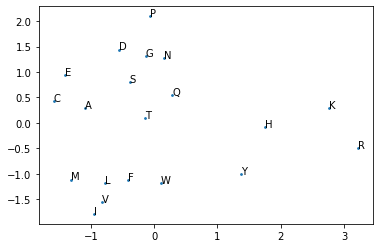

In [12]:
from sklearn.decomposition import PCA

# Use a pca (primary component analysis) to reduce the dimensionality for visual inspection
pca = PCA(2)
embedding_array = model.layers[0].get_weights()[0]
embedding_2d = pca.fit_transform(embedding_array)

import matplotlib.pyplot as plt

# plot the embedding for each amino acid
plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1], s=3)
for key in amino_acid_to_index:
  plt.annotate(key, (embedding_2d[amino_acid_to_index[key], 0], embedding_2d[amino_acid_to_index[key], 1]))

There's still a strong element of reading tea leaves, but one could argue that the hydrophobic amino acids have mostly segregated from the charged/polarizable side chains. Similarly, the positively charge amino acids are well separated from the rest. Considering the marginal gain in accuracy it's unsurprising that we still lack a clear structure here.

At this point we have a few options to push forward:


*   Hyperparameter tuning would like get several points of performance
*   Pretraining our embeddings with an extra dataset of just unlabeled amino acid sequences
*   Chunking our proteins into fixed length sequences

Since we're within a very small margin of our goal of 62.7%, I'll try some architecture/hyperparameter tuning to squeeze out performance.


In [27]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(len(unique_amino_acids_in_train), 4))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(4, return_sequences=True, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3, activation='softmax')))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1E-3), loss='sparse_categorical_crossentropy', metrics=['acc'])

# this is a quick workaround to partially modify the embedding matrix so that the first 3 dimensions match the biophysical properties
embedding_array = model.layers[0].get_weights()[0]
embedding_array[:, :3] = embedding_biophysical_properties
model.layers[0].set_weights([embedding_array])


In [ ]:
model.fit(train_generator, validation_data=test_generator, epochs=80)

In [29]:
from sklearn.metrics import classification_report
predictions = [model.predict(x) for x in test_generator]
print(classification_report([z for _, y in test_generator for x in y for z in x], [np.argmax(z) for y in predictions for x in y for z in x], target_names=['no_structure', 'alpha_helix', 'beta_sheet']))

              precision    recall  f1-score   support

no_structure       0.67      0.85      0.75      1923
 alpha_helix       0.52      0.41      0.46       849
  beta_sheet       0.50      0.28      0.36       748

    accuracy                           0.62      3520
   macro avg       0.56      0.51      0.52      3520
weighted avg       0.60      0.62      0.59      3520



That small change is enough to replicate the 62.7% performance (within the epoch to epoch variation). The original paper asserts that this is a likely ceiling on performance with this dataset so we'll pause here and call it a win.

With 30 years of additional research in deep learning we might expect to not only be able to quickly replicate this performance, but in fact significantly outperform it. My approach here, while on it's surface quite different, shares some deeper similarities with the original sliding window multilayer perceptron. The LSTM despite it's best efforts is not going to meaningfully learn long distance dependencies (see all the recent work with transformers to overcome this) so it is still only capturing local properties of the sequence. Under this view, the bidirectional approach is equivalent to the sliding window being centered on the target amino acid, providing past and future information. It is therefore perhaps unsurprising that it results in very similar performance.

To leverage modern deep learning to go beyond this, I see two clear avenues: pretraining better embeddings and moving to an attention-based architecture such as a transformer. There's a vast corpus of work showing the value of pretraining embeddings now that we have the computational resources to work with very large, unlabeled datasets. Moving to something like a transformer has a decent shot at capturing the long distance dependencies that we know are pivotal to protein structure (conformational changes are a great example of this).